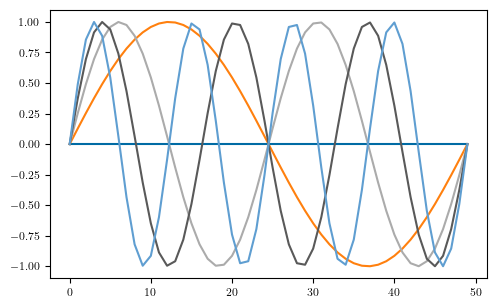

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name, format="pgf"):
    return path.join(FIGURES_PATH, f"{name}.{format}")

plt.style.use(["default", "tableau-colorblind10", STYLE_PATH])

plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()


## Environments

In [2]:
import gym
import gym_search

REPORT_LAYOUT = [
    [0, 0, 0, 1],
    [0, 0, 0, 2],
    [0, 0, 0, 3],
]

SLIDES_LAYOUT = [[0]]

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH

def plot_environment(env_id, seed=0, position=None, layout=REPORT_LAYOUT, width=TEXTWIDTH_IN):
    layout = np.array(layout)
    flattened = layout.flatten()
    unique = set(flattened)
    count = len(unique)
    ratio = layout.shape[0]/layout.shape[1]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=ratio, width=width))
    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0), position=position)

    #fig.tight_layout()

    return fig

In [6]:
plot_environment("Gaussian-v0", seed=1, layout=REPORT_LAYOUT, position=np.array([2, 6])).savefig(figpath("gaussian", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([5, 7])).savefig(figpath("terrain", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([9, 3])).savefig(figpath("camera", format="pgf"), dpi=300, bbox_inches='tight')

In [ ]:
plot_environment("Gaussian-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 3])).savefig(figpath("gaussian", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 12])).savefig(figpath("terrain", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([9, 3])).savefig(figpath("camera", format="pdf"), dpi=300, bbox_inches='tight')

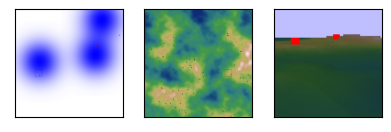

In [13]:
import gym
import gym_search

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH
LAYOUT = [[0, 1, 2]]
ENV_IDS = ["Gaussian-v0", "Terrain-v0", "Camera-v0"]
SEEDS = [0, 0, 0]
POSITIONS = [np.array([9, 3]), np.array([9, 12]), np.array([9, 3])]
RATIO = 1.0/len(LAYOUT)

fig, axs = plt.subplot_mosaic(LAYOUT, figsize=figsize(ratio=RATIO, width=SLIDES_TEXTWIDTH_IN))
envs = [gym.make(env_id) for env_id in ENV_IDS]

for i in range(len(ENV_IDS)):
    ax, env, seed, position = axs[i], envs[i], SEEDS[i], POSITIONS[i]
    env.reset(seed=seed)
    env.plot(ax, overlay=False, position=position)

fig.savefig(figpath("environments", format="pdf"), dpi=300, bbox_inches='tight')

## Experiments

In [ ]:
import csv


NUM_TIMESTEPS = int(25e6)
COLORS = [(57, 106, 177), (218, 124, 48)]

# https://github.com/openai/train-procgen/blob/master/train_procgen

def ema(data_in, smoothing=0):
    data_out = np.zeros_like(data_in)
    curr = np.nan

    for i in range(len(data_in)):
        x = data_in[i]
        if np.isnan(curr):
            curr = x
        else:
            curr = (1 - smoothing) * x + smoothing * curr

        data_out[i] = curr

    return data_out


def plot_data_mean_std(ax, data_y, color_idx=0, data_x=None, x_scale=1, smoothing=0, first_valid=0, label=None):
    color = COLORS[color_idx]
    hexcolor = '#%02x%02x%02x' % color

    data_y = data_y[:,first_valid:]
    nx, num_datapoint = np.shape(data_y)

    if smoothing > 0:
        for i in range(nx):
            data_y[i,...] = ema(data_y[i,...], smoothing)

    if data_x is None:
        data_x = (np.array(range(num_datapoint)) + first_valid) * x_scale

    data_mean = np.mean(data_y, axis=0)
    data_std = np.std(data_y, axis=0, ddof=1)

    ax.plot(data_x, data_mean, color=hexcolor, label=label, linestyle='solid', alpha=1, rasterized=True)
    ax.fill_between(data_x, data_mean - data_std, data_mean + data_std, color=hexcolor, alpha=.25, linewidth=0.0, rasterized=True)


def read_csv(filename, key_name):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        key_index = -1

        values = []

        for line_num, row in enumerate(csv_reader):
            row = [x.lower() for x in row]
            if line_num == 0:
                idxs = [i for i, val in enumerate(row) if val == key_name]
                key_index = idxs[0]
            else:
                values.append(row[key_index])

    return np.array(values, dtype=np.float32)

def plot_values(ax, all_values, title=None, max_x=0, label=None, **kwargs):
    if max_x > 0:
        all_values = all_values[...,:max_x]

    if ax is not None:
        plot_data_mean_std(ax, all_values, label=label, **kwargs)
        ax.set_title(title)

    return all_values

### Search Space

## Extra

### Tensorboard

KeyboardInterrupt: 

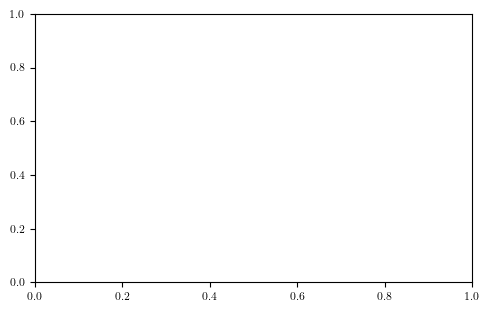

In [4]:
from glob import glob
from scipy import stats
from functools import lru_cache
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE


def load_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    df = pd.DataFrame(scalars)
    return df


def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

def plot_runs(data, tag, xlabel="step", ylabel="value", smoothing=0.0, outliers=False, initial=0):
    fig, ax = plt.subplots(figsize=figsize())

    for label, runs in data.items():

        data_y = []

        for path in runs:
            df = load_scalars(path, tag)
            y = df.value[df.step >= initial]

            #if not outliers:
            #    df = df[(np.abs(stats.zscore(df["value"])) < 3)]
            
            data_y.append(y)

            #p = ax.plot(x, smooth(list(y), smoothing), label=label)
            
            #ax.plot(x, y, alpha=0.25, color=p[0].get_color())            

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title("test")
    ax.legend(frameon=False)
    
    return fig

#data = {
    "lstm": [f"logs/train/map/shape/s/r1/{seed}" for seed in range(1, 4)],
#}

#fig = plot_runs(data, "episode/length", ylabel="length", smoothing=0.999, initial=1000000)

### Latent Images

In [1]:
import torch as th
import numpy as np
from sklearn.decomposition import PCA

import rl
import gym
import gym_search

def image_decomposition(x):
    h, w, c = x.shape
    if c == 3: return x
    x = x.flatten().reshape(h*w, c)
    pca = PCA(n_components=3).fit(x)
    y = pca.transform(x)
    img = y.reshape(h, w, 3)
    img *= (255.0/img.max())
    return np.abs(img)

#device = th.device("cpu")
#envs = gym.vector.make("Terrain-v0", num_envs=1)
#agent = th.load("models/baseline-small.pt").to(device)
#obs = envs.reset()